# MNIST 데이터셋 학습 (to do)
MNIST 데이터셋은0~9까지 총 10개의 label로 이루어진 이미지 분류를 위한 사이즈의 손글씨 데이터셋이다.  
각각의 레이블마다 28×28 크기 이미지인 60,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 70,000개의 28×28 크기의 이미지로 데이터셋이 구성되어 있다.

In [1]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation

import os
import numpy as npame  
import matplotlib.pyplot as plt
%matplotlib inline

## (1) 데이터셋

In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape)

(60000, 28, 28) (60000,)


In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

(60000, 28, 28, 1) (60000, 10)


In [6]:
import numpy as np
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [7]:
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

## (2) 모델링

2022-09-08 19:41:38.757626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-08 19:41:38.757661: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-08 19:41:38.758598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

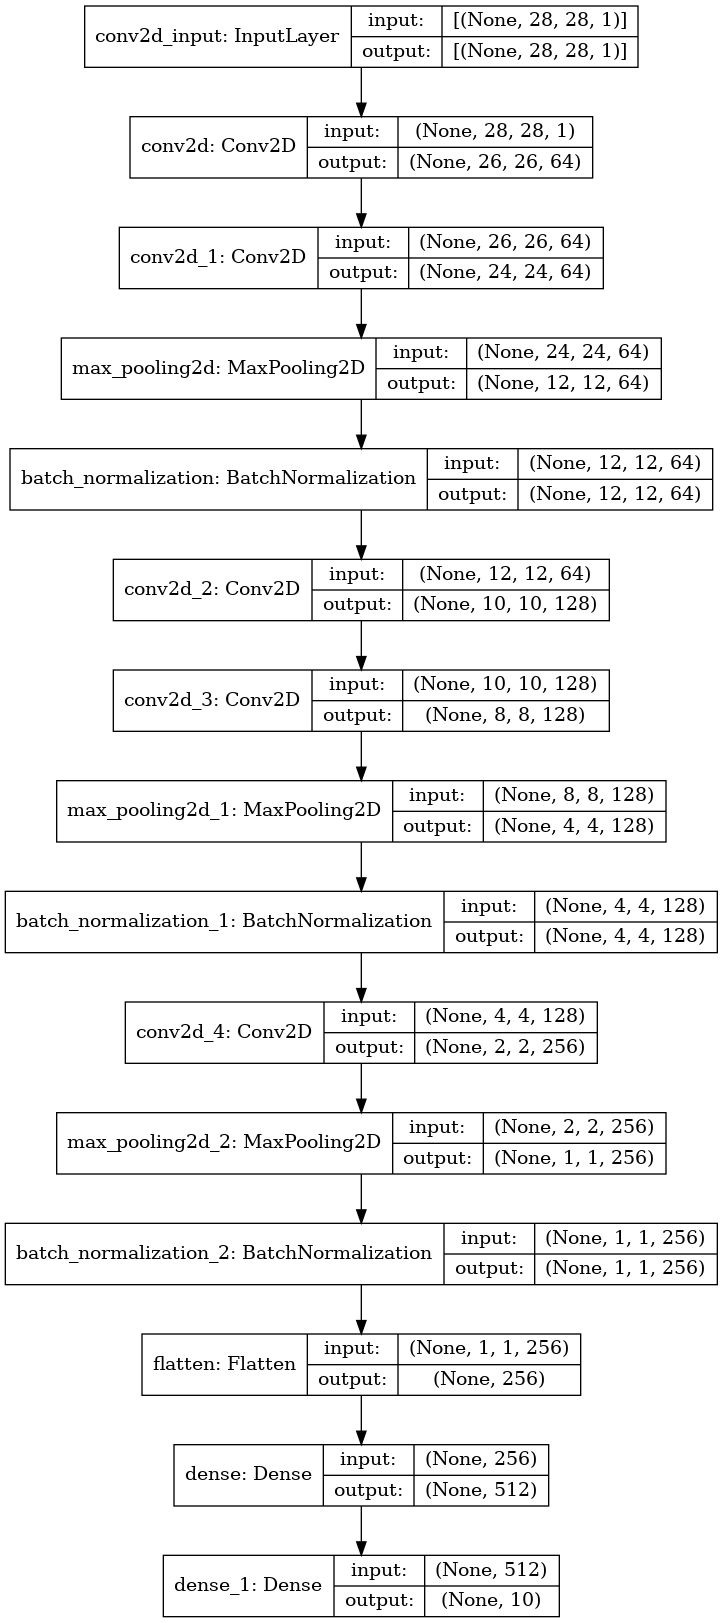

In [8]:
def CNN_Dropout(n_in, n_out):
    
    model = Sequential()
    #model.add(Lambda(standardize,input_shape=(28,28,1)))    
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())    

    model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512,activation="relu"))

    model.add(Dense(10,activation="softmax"))
    
    return model

model=CNN_Dropout(n_in, n_out)
model.summary()

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, Y_train, batch_size=128)
test_gen = datagen.flow(X_test, Y_test, batch_size=128)

## (3) 모델의 학습과정 설정

In [10]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## (4) 모델 학습시키기

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

def build_lrfn(lr_start=1e-4, lr_max=1e-3, 
               lr_min=0, lr_rampup_epochs=16, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr

    return lrfn
lrfn = build_lrfn()
lr_schedule = LearningRateScheduler(lrfn, verbose=True)
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks = [earlystopper,lr_schedule])

2022-09-08 19:41:39.551456: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1500/1500 [==============================] - 144s 96ms/step - loss: 0.1377 - accuracy: 0.9620 - val_loss: 0.0505 - val_accuracy: 0.9848
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.00015625.
1500/1500 [==============================] - 142s 95ms/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.00021250000000000002.
1500/1500 [==============================] - 140s 94ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0348 - val_accuracy: 0.9892
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00026875.
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0306 - accuracy: 0.9905 - val_loss: 0.0323 - val_accuracy: 0.9893
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.000325.
1500/1500 [==============

## (5) 모델 평가하기

In [12]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 6s 77ms/step - loss: 0.0315 - accuracy: 0.9946
loss : 0.0315, accruracy : 0.9946


## (6) 모델 사용하기

모델 평가 후, 분류 오류가 난 사례들을 확인해보고, 모델과 데이터셋에 대한 평가 및 분석해볼 것

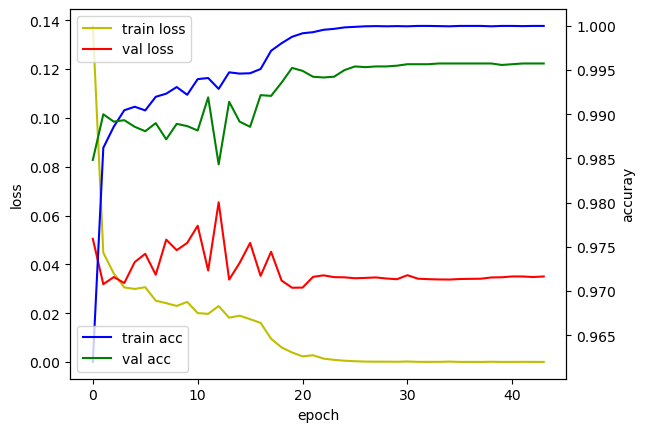

In [13]:
# matplotlib를 이용하여 history 객체 내부에 저장된 값들을 graph로 표현

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
 
acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

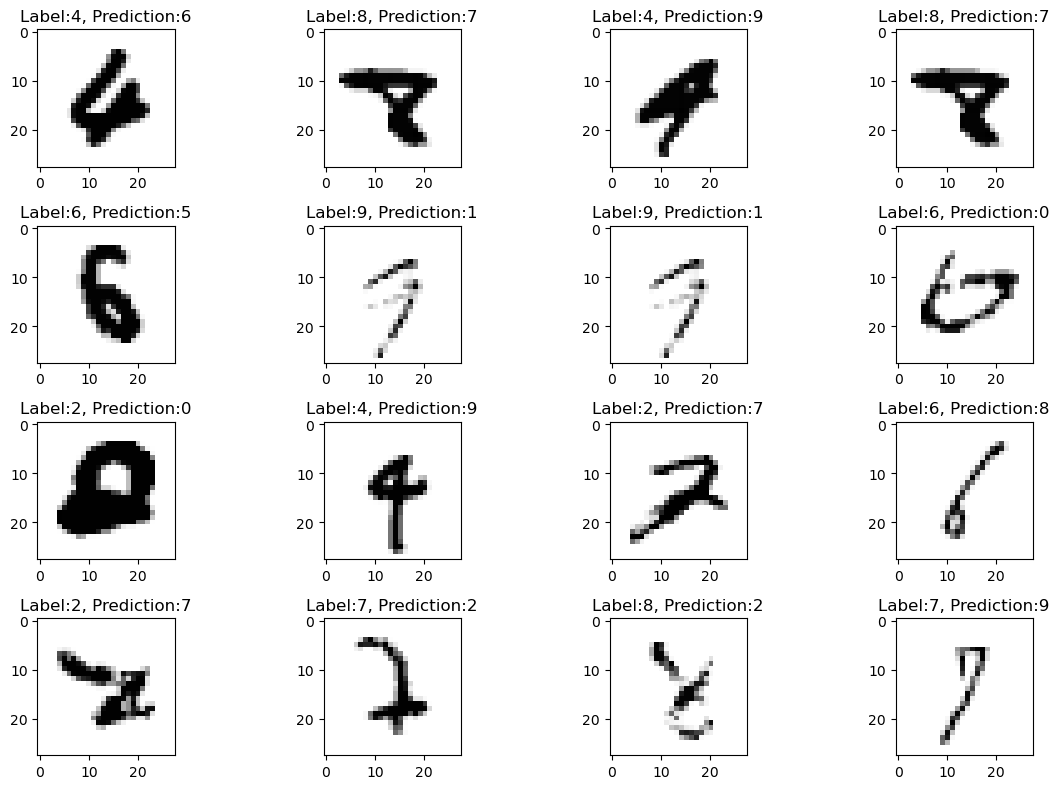

In [14]:
import random

predicted_result = model.predict(X_test)
predicted_labels = np.argmax(predicted_result, axis=1)
test_labels = np.argmax(Y_test, axis=1)

wrong_result = []
for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)
samples = random.choices(population=wrong_result, k=16)
count = 0
nrows = ncols = 4
plt.figure(figsize=(12,8))
for n in samples:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(X_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)
plt.tight_layout()
plt.show() 

 

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(test_labels, predicted_labels)
confusion

array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0, 1026,    0,    0,    0,    0,    5,    0,    0],
       [   0,    1,    0, 1006,    0,    3,    0,    0,    0,    0],
       [   0,    0,    1,    0,  976,    0,    1,    0,    0,    4],
       [   0,    0,    0,    4,    0,  887,    1,    0,    0,    0],
       [   6,    2,    0,    0,    1,    1,  947,    0,    1,    0],
       [   0,    3,    2,    1,    0,    0,    0, 1021,    0,    1],
       [   1,    0,    1,    0,    0,    1,    0,    1,  970,    0],
       [   0,    1,    1,    0,    5,    1,    0,    1,    0, 1000]])